In [1]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from tqdm import tqdm
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
import glob
import tensorflow as tf

C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\

C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [3]:
tflib.init_tf()

In [4]:
model_path = "./results/vm/landscapes/network-snapshot-006126.pkl" 
model_path = "./results/vm/landscapes/network-snapshot-008040.pkl"

with open(model_path, "rb") as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
rnd = np.random.RandomState(0)
c = np.tile(np.eye(4)[1],(10,1))
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

In [6]:
qlatent_data = []
dlatent_data = []
labels_data = []

In [7]:
def get10():
    qlatents = np.random.normal(size=(10, 512))
    qlatent_data.extend(qlatents)
    dlatents = Gs_network.components.mapping.run(qlatents,
                                                 c, 
                                                 minibatch_size=10, 
                                                 randomize_noise=False, 
                                                 structure='fixed')
    dlatent_data.extend(dlatents)
    images = Gs_network.components.synthesis.run(dlatents, 
                                                 minibatch_size=10, 
                                                 randomize_noise=False, 
                                                 output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
                                                 structure='fixed')
    images2 = Gs_network.run(qlatents,c,truncation_psi=0.7, randomize_noise=False, output_transform=fmt)
    return images2

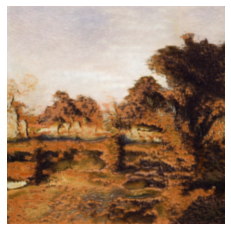

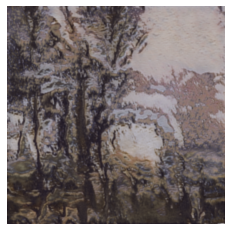

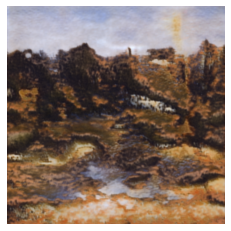

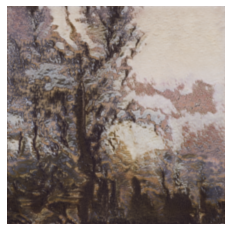

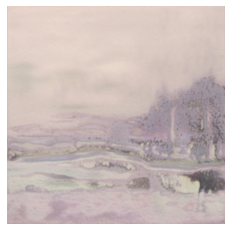

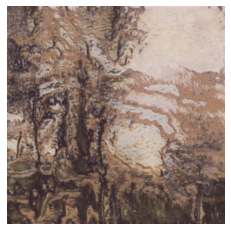

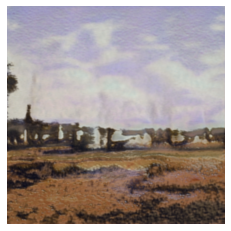

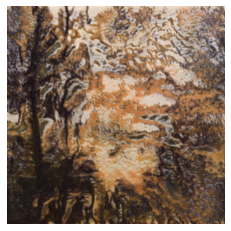

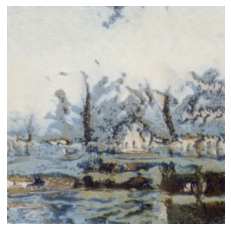

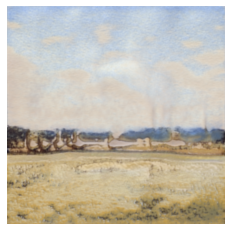

In [8]:
for im in get10():
    img = PIL.Image.fromarray(im, 'RGB')
    plt.imshow(img,interpolation='bicubic')
    plt.axis('off')
    plt.show()

In [9]:
model = VGG16(weights='imagenet')

In [10]:
def getlabels(images2):
    for img in images2:
        img = PIL.Image.fromarray(img, 'RGB')
        img = img.resize((224,224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        labels_data.append(decode_predictions(preds,top=5))
    

In [11]:
for _ in tqdm(range(100)):
    x = get10()
    getlabels(x)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:07<00:00,  3.67s/it]


In [13]:
labels_data[998]

[[('n03743016', 'megalith', 0.121843),
  ('n03733281', 'maze', 0.11180595),
  ('n09246464', 'cliff', 0.067719),
  ('n04326547', 'stone_wall', 0.059476893),
  ('n02980441', 'castle', 0.055917747)]]

In [14]:
pickle.dump((qlatent_data, dlatent_data, labels_data), open("latent_training_data1000.p", "wb"))

In [15]:
from collections import Counter

In [16]:
countlabels = []
for x in labels_data:
    for y in x:
        countlabels.append(y[0][1])
Counter(countlabels).most_common(10)

[('geyser', 182),
 ('cliff', 127),
 ('valley', 94),
 ('lakeside', 88),
 ('maze', 65),
 ('stone_wall', 54),
 ('fountain', 52),
 ('ant', 32),
 ('sandbar', 30),
 ('megalith', 29)]